In [19]:
#importing the libraries
import heapq
import random as rd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# code addapeted from session 5

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [4]:
#part of this code was also from class

class Queue:
    #after I finished everything, I realized that this class was unecessary, but I dont want to change the whole code now
    def __init__(self):
        # We start with an empty queue
        self.people_in_queue = 0

    def add_customer(self):
        # Add the customer to the queue
        self.people_in_queue += 1
    
    def embark(self, n):
        #tke person from the queue
        self.people_in_queue -= n

class Bus:
    def __init__(self, initial_stop, 
                nStops=15, 
                time_moving_dist=sts.norm(loc=2,scale=0.5), 
                load_time_dist=sts.norm(loc = 0.03, scale = 0.01), 
                unload_time_dist=sts.norm(loc=0.05, scale = 0.01), 
                max_pass=130):

        """initializing a new bus with the given parameters"""
        self.nPassengers = 0
        self.cStop = initial_stop  #current stop
        self.time_moving_dist = time_moving_dist
        self.max_pass = max_pass  #max number of passegerns
        self.load_time_dist = load_time_dist
        self.unload_time_dist = unload_time_dist
        self.nStops = nStops  #number of stops of the system
        self.stops = {i:0 for i in range(nStops)}  #dictionary of stops and how many people are getting off in each

    def Load(self, *args):
        """adds people to the bus"""

        #getting the parameters
        schedule = args[0]
        busSystem, stop= args[1]

        #the number of people getting in is defined by the number of people wating
        #if it exeeds the max capacity of the bus, just fill it up
        n = busSystem.queues[stop].people_in_queue 
        if n + self.nPassengers > self.max_pass:
            n = self.max_pass - self.nPassengers
        self.nPassengers += n

        #for every parson getting in, uniformily choose one of the nex 7 stops for them to get out
        for _ in range(n):
            trip = stop + round(rd.random()*7)
            if trip > self.nStops-1:
                trip -= self.nStops
            self.stops[stop] += 1

        busSystem.queues[stop].embark(n) #removes person from the queue

        #once everyone is loaded, schedule the unloading in the next stop
        #counting also the time to move there and the time that it took to load
        schedule.add_event_after(
            self.time_moving_dist.rvs()+self.load_time_dist.rvs()*n,
            self.Unload, (busSystem, self.cStop+1))
    
    def Unload(self, *args):
        """takes people out of the bus"""

        #getting the parameters
        schedule = args[0]
        busSystem, stop= args[1]

        #"returns" to stop 0 if the stop exeeds the number of stops
        if stop > self.nStops-1:
            stop -= self.nStops
        self.cStop = stop

        #getts the number of passengers getting off from the dictionary
        n = self.stops[stop]

        #takes them out 
        self.nPassengers -= n
        self.stops[stop] -= n

        #schedules the loading of the passengers
        #including the unloading time
        schedule.add_event_after(
            self.unload_time_dist.rvs()*n,
            self.Load, (busSystem, self.cStop))

class BusSystem:
    def __init__(self, n_busses, 
                arrival_distribution=sts.expon(scale=1),
                bus_interval_dist = sts.norm(loc=4, scale=0.5), 
                n_stops=15):

        """initializing a new bus with the given parameters"""
        self.queues = {i:Queue() for i in range(n_stops)}  #dict of queues
        self.arrival_distribution = arrival_distribution
        self.n_stops = n_stops
        self.busses = {i:Bus(0) for i in range(n_busses)}  #dict of busses
        self.bus_interval_dist = bus_interval_dist  #distribution of the time between each bus leaving the initial stop

    def add_customer(self, *args):
        """adds a passenger to a queue"""
        
        #gets the parameters
        queue, schedule = args[1]

        # Add this customer to the queue
        self.queues[queue].add_customer()
        
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer, (queue, schedule))

    def run(self, schedule):
        """initializes the system"""

        # Schedule when the first customer arrives in each stop
        for i in range(self.n_stops):
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer, (i, schedule))

        #Schedule when the busses leave from the initial stop (0)
        for i,bus in self.busses.items():
            schedule.add_event_after(
                self.bus_interval_dist.rvs()*(i+1),
                bus.Load, (self,0))
        

def run_simulation(n_busses, run_until):
    """runs the simulation, outputing the total number of people waiting at each timestamp"""
    schedule = Schedule()
    bus_system = BusSystem(n_busses)
    bus_system.run(schedule)
    people_waiting = []
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
        people_waiting.append(sum([bus_system.queues[i].people_in_queue for i in range(len(bus_system.queues))]))
    return people_waiting

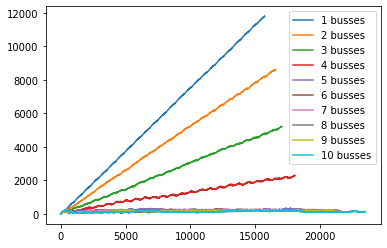

In [9]:
n = 10
start_n = 1
sims=[run_simulation(i, 1000) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.title('Total number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

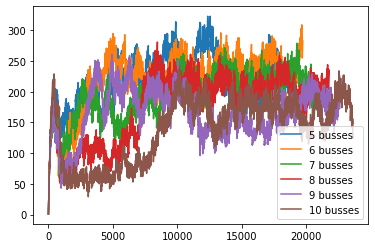

In [15]:
n = 10
start_n = 5
sims=[run_simulation(i, 1000) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.title('Total number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

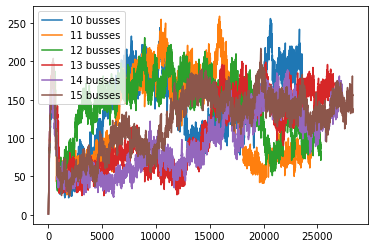

In [13]:
n = 15
start_n = 10
sims=[run_simulation(i, 1000) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.title('Total number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

average total number of people wating:  249.3699217710606


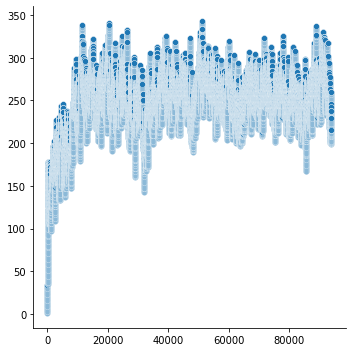

In [18]:
y=run_simulation(i, 5000)

print('average total number of people wating: ', np.mean(y))
sns.relplot(x=range(len(y)), y=y)

plt.title('Total number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

In [99]:
def run_simulation_data(n_busses, run_until):
    """runs the simulation, outputing the full data on the number of people in every stop and bus at each timestamp"""
    schedule = Schedule()
    bus_system = BusSystem(n_busses)
    bus_system.run(schedule)
    busses = [[] for _ in bus_system.busses]
    stops = [[] for _ in bus_system.queues]
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
        for i in range(len(bus_system.busses)):
            busses[i].append(bus_system.busses[i].nPassengers)
        for i in range(len(bus_system.queues)):
            stops[i].append(bus_system.queues[i].people_in_queue)
    
    df_bus = pd.DataFrame.from_dict({f'people_in_bus_{i}':busses[i] for i in range(len(busses))})
    df_stops = pd.DataFrame.from_dict({f'people_in_stop_{i}':stops[i] for i in range(len(stops))})
    
    return pd.concat([df_bus, df_stops], axis=1)


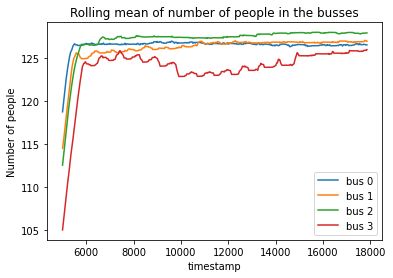

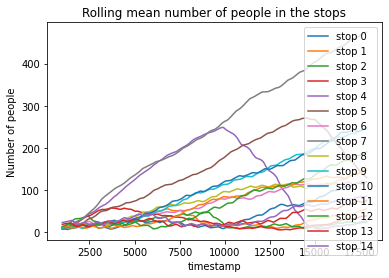

In [132]:
n_busses = 4

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.title('Rolling mean of number of people in the busses')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

plt.legend()
plt.title('Rolling mean number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

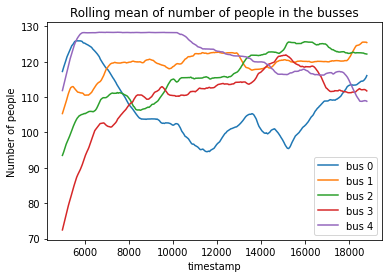

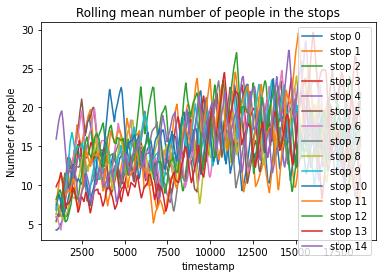

In [133]:
n_busses = 5

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.title('Rolling mean of number of people in the busses')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

plt.legend()
plt.title('Rolling mean number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

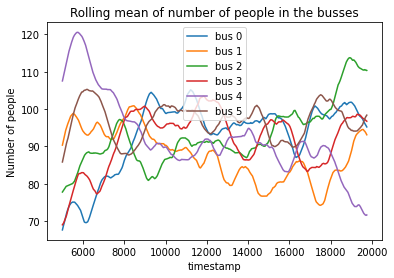

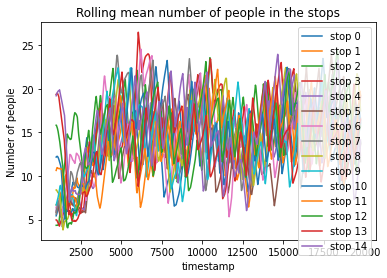

In [134]:
n_busses = 6

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.title('Rolling mean of number of people in the busses')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

plt.legend()
plt.title('Rolling mean number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

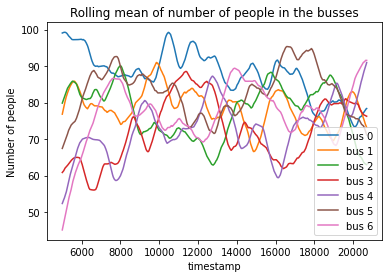

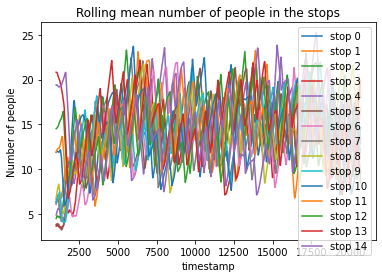

In [135]:
n_busses = 7

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.title('Rolling mean of number of people in the busses')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

plt.legend()
plt.title('Rolling mean number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

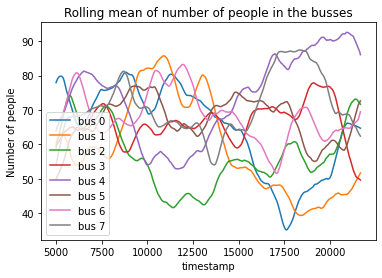

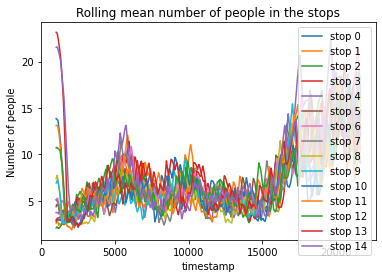

In [136]:
n_busses = 8

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.title('Rolling mean of number of people in the busses')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

plt.legend()
plt.title('Rolling mean number of people in the stops')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

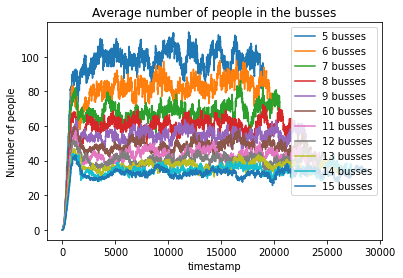

In [125]:
n = 15
start_n = 5
sims=[run_simulation_data(i, 1000).iloc[: , :i+1].mean(1) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.title('Average number of people in the busses')
plt.xlabel('timestamp')
plt.ylabel('Number of people')
plt.show()

In [112]:
#this might take a long time to run, I dont recomend re-runing it
n = 15
start_n = 1
sims=[[run_simulation_data(i, 1000).iloc[: , i:].max().max() for _ in range(100)] for i in range(start_n,n+1)]

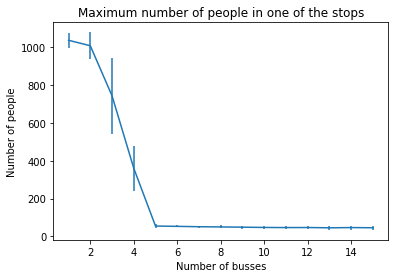

In [121]:
plt.errorbar(x=range(start_n, n+1), y=[np.mean(i) for i in sims], yerr=[1.96*np.std(i) for i in sims])
plt.title('Maximum number of people in one of the stops')
plt.xlabel('Number of busses')
plt.ylabel('Number of people')
plt.show()

In [128]:
#this might also take a little while to run 5x less than the other tho
n = 15
start_n = 5
sims=[[run_simulation_data(i, 1000).iloc[: , i:].max().max() for _ in range(100)] for i in range(start_n,n+1)]

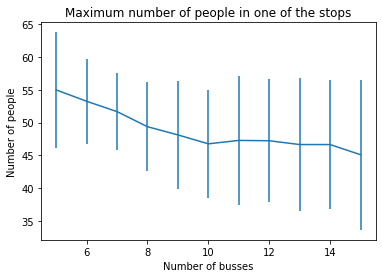

In [129]:
plt.errorbar(x=range(start_n, n+1), y=[np.mean(i) for i in sims], yerr=[1.96*np.std(i) for i in sims])
plt.title('Maximum number of people in one of the stops')
plt.xlabel('Number of busses')
plt.ylabel('Number of people')
plt.show()

In [130]:
n = 15
start_n = 5
sims=[[run_simulation_data(i, 1000).iloc[: , :i+1].mean().mean() for _ in range(100)] for i in range(start_n,n+1)]

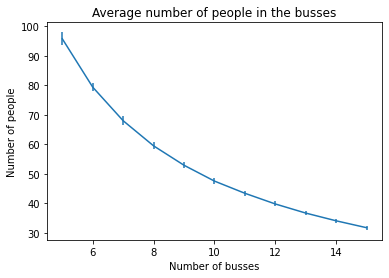

In [131]:
plt.errorbar(x=range(start_n, n+1), y=[np.mean(i) for i in sims], yerr=[1.96*np.std(i) for i in sims])
plt.title('Average number of people in the busses')
plt.xlabel('Number of busses')
plt.ylabel('Number of people')
plt.show()